In [ ]:
# import sys
# print(sys.executable)
# !{sys.executable} -m pip install antropy

/opt/anaconda3/bin/python
  Using cached antropy-0.1.9-py3-none-any.whl.metadata (6.6 kB)
Using cached antropy-0.1.9-py3-none-any.whl (18 kB)


In [1]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import antropy as ant

In [2]:
ALL = True

In [3]:
if ALL: 
    DATA_SOURCE = "book_popularity.parquet"
else: 
    DATA_SOURCE = "case_studies.parquet"

In [4]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
nlp.add_pipe("sentencizer")
nlp.max_length = 2_000_000

In [5]:
df = pd.read_parquet(DATA_SOURCE)

In [15]:
def generate_ap_stats(text, max_words=15000, use_sentences=True, order=2):
    
    
    sentences = text.split(". ")

    if use_sentences:
        max_sentences = 500
        truncated = sentences[-max_sentences:]
        truncated_text = ". ".join(truncated)
    else:

        truncated_sentences = []
        current_word_count = 0

        for sentence in reversed(sentences):
            sentence_word_count = len(sentence.split())

            if current_word_count + sentence_word_count > max_words:
                break

            truncated_sentences.append(sentence)
            current_word_count += sentence_word_count

        truncated_sentences = list(reversed(truncated_sentences))
        truncated_text = ". ".join(truncated_sentences)

    # nlp processing 
    doc = nlp(truncated_text)

    sentence_lengths = []
    word_lengths = []

    for sent in doc.sents:
        tokens = [t for t in sent if t.is_alpha]
        sentence_lengths.append(len(tokens))

        for token in tokens:
            word_lengths.append(len(token.text))

    sentence_lengths = np.array(sentence_lengths)
    word_lengths = np.array(word_lengths)

    # calculating apen
    if len(sentence_lengths) < order + 1:
        sentence_apen = np.nan
    else:
        sentence_apen = ant.app_entropy(sentence_lengths, order=order, tolerance=0.5*np.std(sentence_lengths))

    if len(word_lengths) < order + 1:
        word_apen = np.nan
    else:
        word_apen = ant.app_entropy(word_lengths, order=order)

    return pd.Series({
        "sentence_apen": sentence_apen,
        "word_apen": word_apen,
        "length": len(truncated_text)
    })


df[['sentence_apen', 'word_apen', 'length']] = df["text"].apply(generate_ap_stats)
df.head(5)

,title,authors,download_count,text,sentence_apen,word_apen,length
0,"Frankenstein; Or, The Modern Prometheus","[Shelley, Mary Wollstonecraft]",147950,"Frankenstein;\r\n\r\nor, the Modern Prometheus...",1.229979,2.074008,103775.0
1,"Moby Dick; Or, The Whale","[Melville, Herman]",116573,"MOBY-DICK;\r\n\r\nor, THE WHALE.\r\n\r\nBy Her...",0.928607,1.964250,131811.0
2,Pride and Prejudice,"[Austen, Jane]",86747,[Illustration:\r\n\r\n ...,0.997877,2.033840,83465.0
3,Romeo and Juliet,"[Shakespeare, William]",69731,THE TRAGEDY OF ROMEO AND JULIET\r\n\r\nby Will...,0.884833,1.947659,147729.0
4,Simple Sabotage Field Manual,[United States. Office of Strategic Services],59276,[Illustration]\r\n\r\n\r\n\r\n\r\nSimple Sabot...,1.188703,2.090847,55426.0


In [16]:
df.head(5)

,title,authors,download_count,text,sentence_apen,word_apen,length
0,"Frankenstein; Or, The Modern Prometheus","[Shelley, Mary Wollstonecraft]",147950,"Frankenstein;\r\n\r\nor, the Modern Prometheus...",1.229979,2.074008,103775.0
1,"Moby Dick; Or, The Whale","[Melville, Herman]",116573,"MOBY-DICK;\r\n\r\nor, THE WHALE.\r\n\r\nBy Her...",0.928607,1.964250,131811.0
2,Pride and Prejudice,"[Austen, Jane]",86747,[Illustration:\r\n\r\n ...,0.997877,2.033840,83465.0
3,Romeo and Juliet,"[Shakespeare, William]",69731,THE TRAGEDY OF ROMEO AND JULIET\r\n\r\nby Will...,0.884833,1.947659,147729.0
4,Simple Sabotage Field Manual,[United States. Office of Strategic Services],59276,[Illustration]\r\n\r\n\r\n\r\n\r\nSimple Sabot...,1.188703,2.090847,55426.0


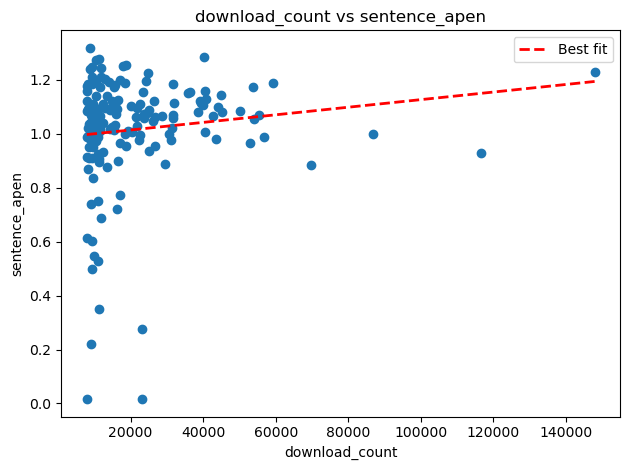

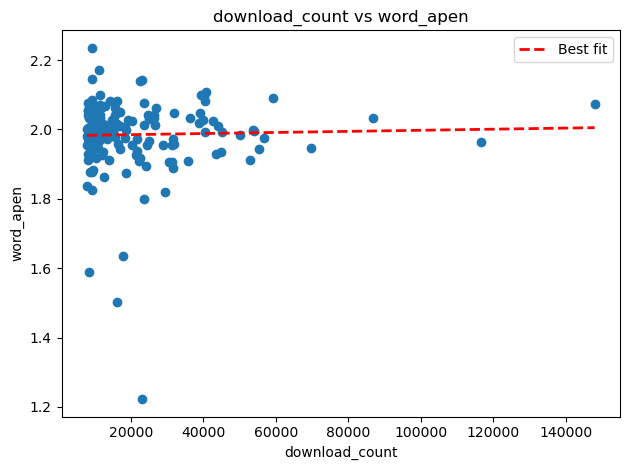

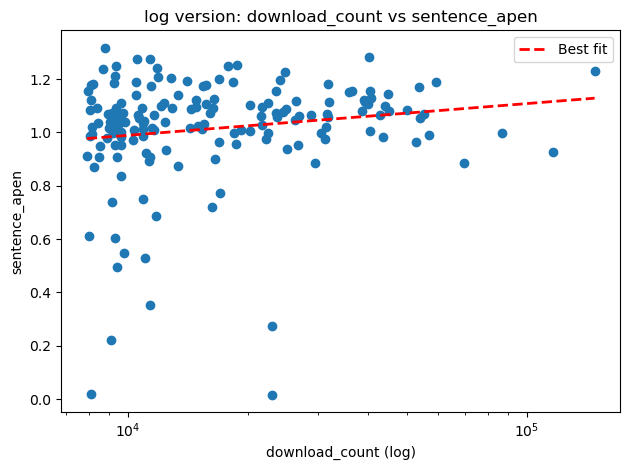

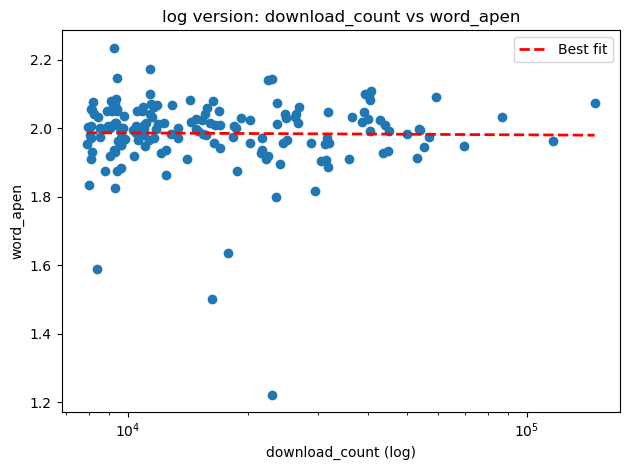

In [ ]:
def generate_plot(x, y, log=False, y_range=None, ALL=True, line_of_best_fit=True):

    if ALL:
        df_plot = df.copy()

        df_plot = df_plot[[x, y]].replace([np.inf, -np.inf], np.nan).dropna()

        if y_range is not None:
            y_min, y_max = y_range
            df_plot = df_plot[(df_plot[y] >= y_min) & (df_plot[y] <= y_max)]

        if log:
            df_plot = df_plot[df_plot[x] > 0]

        if len(df_plot) < 2:
            print("Not enough data to fit regression.")
            return

        x_vals = df_plot[x].values
        y_vals = df_plot[y].values

        plt.figure()
        plt.scatter(x_vals, y_vals)

        if line_of_best_fit:

            if log:
                log_x = np.log10(x_vals)
                coeffs = np.polyfit(log_x, y_vals, 1)
                fit_line = np.poly1d(coeffs)

                x_sorted = np.sort(x_vals)
                y_fit = fit_line(np.log10(x_sorted))

            else:
                coeffs = np.polyfit(x_vals, y_vals, 1)
                fit_line = np.poly1d(coeffs)

                x_sorted = np.sort(x_vals)
                y_fit = fit_line(x_sorted)

            plt.plot(x_sorted, y_fit,
                     linestyle='--',
                     linewidth=2,
                     color='red',
                     label='Best fit')

            plt.legend()

        if log:
            plt.xscale("log")
            plt.xlabel(f"{x} (log)")
            plt.title(f"log version: {x} vs {y}")
        else:
            plt.xlabel(x)
            plt.title(f"{x} vs {y}")

        plt.ylabel(y)

        if y_range is not None:
            plt.ylim(y_min, y_max)

        plt.tight_layout()
        plt.show()


if ALL:
    generate_plot("download_count", "sentence_apen")
    generate_plot("download_count", "word_apen")

    generate_plot("download_count", "sentence_apen", log=True)
    generate_plot("download_count", "word_apen", log=True)

else: 
    generate_plot("title", "sentence_apen")
    generate_plot("title", "word_apen")